# Practical Machine Learning that Scales: Using H2O with Python to Accelerate ML and DL

### Brian Griner

June 5, 2018

NYC Big Data Meetup

![title](http://scikit-learn.org/stable/_images/sphx_glr_plot_partial_dependence_002.png)

***
## Intro
If tuned properly, machine learning (ML) and deep learning (DL) algorithms are very powerful. However, the process of tuning an algorithm can increase the time it takes to do an analysis exponentially. While Python is a very expressive language for data science with lots of libraries for machine learning and deep learning, there are aspects of the language that can significantly slow down the process of algorithms tuning. For example, Python's use of global interpreter lock (GIL) that restricts processing to one instruction at a time regardless of the number of cores available. Fortunately there are programs to speed up the tuning process in Python like H2O. 

As you will see shortly, the H2O environment for Python is easy to use and can be run from a Jupyter Notebook. To demonstrate, we will review several ML and DL algorithms in H2O as well as modules in H2O for tuning them. We we also review H2O partial dependence plot graph feature that can be used to plot changes in feature importance over the domain of the model inputs for many ML algorithms. This notebook contains the material reiviewed in the presentation to help jump start your journey with H2O.

Let us begin by posing a pragmatic question that is often hard to address when using ML or DL for business research. 

## Outline
1. **Problem Statement** - How can we better understand Cause and Effect between inputs and outputs when using a complex machine learning or deep learning algorithm?

2. **Feature Importance** - What is _Importance_? How do we measure it with?
    - Linear models
    - Machine learning algorithms
    - Neural Networks


3. **Partial Dependence Plots** demonstrated with Gradient Boosting Machine

4. **Ensemble Learning**

5. **End-to-End** ML


**Research on Partial Dependence Plots**

[Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation
Alex Goldstein∗, Adam Kapelner†, Justin Bleich‡, and Emil Pitkin§
The Wharton School of the University of Pennsylvania](https://arxiv.org/pdf/1309.6392.pdf)


## The problem with using ML algorithms in business 

A. ML algorithms are hard to explain to your internal clients. "Gradient Boosting what??? Oh, I get it. You used A.I., right?"

B. Many business problems require interpretation of model results (especially when the answer is the opposite of what the CEO wants it to be). Some examples in commercial analytics include:

- What are the key drivers of new customer aquisition?
- Which marketing promotions are driving business performance?
- Is there a mix of promotional channels that will maximize my return on promotional spend?
- How much should I spend on each promotional channel; i.e. what is the media mix?
- Why is the forecast 20 percent lower than last year?
- What can I do to make it 20 percent higher than last year? That is our mandate from the CEO.

C. The connection between "cause" and "effect" in ML algorithms can be complicated or impossible to determine analytically. For example, using the gradients of a multilayer neural network or computing the marginal effects of the inputs from an ensemble learning algorithm.

## Feature Importance

In machine learning, feature importance is one way to understand the relative performace of an input. A simple explanation of how feature importance is determined in machine learning is **to examine the change in out of sample predictive accuracy when each one of the inputs is changed.**

Some basic examples using the Pima Indians diabetes from UCI ML repository is presented below.
***

## Data Prep

In [2]:
# Test h2o
%matplotlib inline
import h2o
#from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# initialize h2o
h2o.init()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

names = ['preg', 'gluc', 'dbp', 'skin', 'insul', 'bmi', 'pedi', 'age', 'class']
#diabetes = h2o.import_file('pima-indians-diabetes.csv', col_names = names)
diabetes = h2o.import_file(path='https://raw.githubusercontent.com/cxd/au.id.cxd.Math/master/data/test-pima-diabetes/raw-pima-indians-diabetes.csv', col_names = names)

print(diabetes.columns)
print(diabetes.head())
print(diabetes.describe())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,7 hours 43 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,3 months and 1 day
H2O cluster name:,H2O_from_python_briangriner_7h9a8x
H2O cluster total nodes:,1
H2O cluster free memory:,3.220 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
['preg', 'gluc', 'dbp', 'skin', 'insul', 'bmi', 'pedi', 'age', 'class']


preg,gluc,dbp,skin,insul,bmi,pedi,age,class
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0,0.232,54,1



Rows:768
Cols:9




,preg,gluc,dbp,skin,insul,bmi,pedi,age,class
type,int,int,int,int,int,real,real,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
mean,3.845052083333336,120.89453125,69.10546874999994,20.536458333333357,79.79947916666666,31.99257812500003,0.4718763020833334,33.240885416666615,0.3489583333333333
maxs,17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0
sigma,3.36957806269887,31.972618195136224,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.47695137724279896
zeros,111,5,35,227,374,11,0,0,500
missing,0,0,0,0,0,0,0,0,0
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0


None


## ML & DL Algorithm Review

In [6]:
# data prep for model

# set columns names for model inputs and output
#inputs = ['preg', 'gluc', 'dbp', 'skin', 'insul', 'bmi', 'pedi', 'age']
#output = 'class'

# create training and test datasets for model validation
train, valid = diabetes.split_frame(ratios = [.8], seed = 4321)

# Identify predictors and response
inputs = train.columns
output = "class"
inputs.remove(output)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# baseline models

# glm
from h2o.estimators import H2OGeneralizedLinearEstimator
diabetes_glm = H2OGeneralizedLinearEstimator(family = "binomial", model_id = "glm_default.hex", seed = 4321)
diabetes_glm.train(x = inputs, y = output, training_frame = train, validation_frame = valid)

# H2ORandomForestEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
diabetes_RF = H2ORandomForestEstimator(seed = 7654321) # nbins_cats = num, seed = 4321)
diabetes_RF.train(x = inputs, y = output, training_frame = train, validation_frame = valid)
    
# H2OGradientBoostingEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
diabetes_gbm = H2OGradientBoostingEstimator(seed = 7654321) # nbins_cats = num, seed = 4321)
diabetes_gbm.train(x = inputs, y = output, training_frame = train, validation_frame = valid)
    
# DL
from h2o.estimators import H2ODeepLearningEstimator
diabetes_dl = H2ODeepLearningEstimator(model_id = "dl_default.hex", seed = 4321)
diabetes_dl.train(x = inputs, y = output, training_frame = train, validation_frame = valid)
    
# model comparison table
header = ["Model", "Training AUC", "Validation AUC"]
table = [
    ["GLM", diabetes_glm.auc(train = True), diabetes_glm.auc(valid = True)],
    ["DRF", diabetes_RF.auc(train = True), diabetes_RF.auc(valid = True)],
    ["GBM", diabetes_gbm.auc(train = True), diabetes_gbm.auc(valid = True)],
    ["DL", diabetes_dl.auc(train = True), diabetes_dl.auc(valid = True)]
]
h2o.display.H2ODisplay(table, header)

glm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


Model,Training AUC,Validation AUC
GLM,0.8452474,0.8062954
DRF,0.8057321,0.8304220
GBM,0.9827656,0.8265306
DL,0.8594646,0.8056036


Model,Training AUC,Validation AUC
GLM,0.8452474,0.8062954
DRF,0.8057321,0.8304220
GBM,0.9827656,0.8265306
DL,0.8594646,0.8056036


## CV Plot on Number of Trees

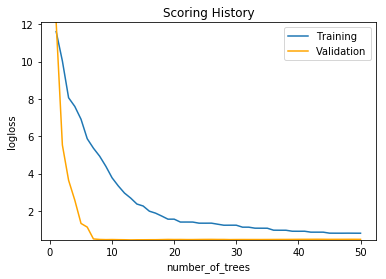

In [7]:
diabetes_RF.plot()

**Conclusion: overfit and in need of tuning - memorized the validation data**

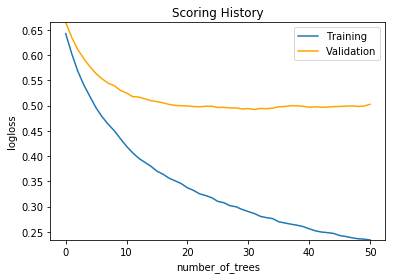

In [8]:
diabetes_gbm.plot()

**Conclusion: high variance and complexity - need to optimize hyper parameters**

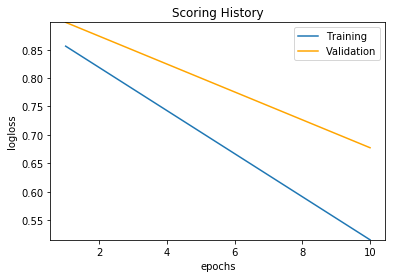

In [9]:
diabetes_dl.plot()

**Conclusion: underfit - prediction error on validation data drops slowly but clearly we can do better with tuning and additional training**

## Feature Importance
***
In machine learning, feature importance is used to understand the relative performace of an input. A simple explanation of how feature importance is determined in machine learning is **to examine the change in out of sample predictive accuracy when each one of the inputs is changed.**

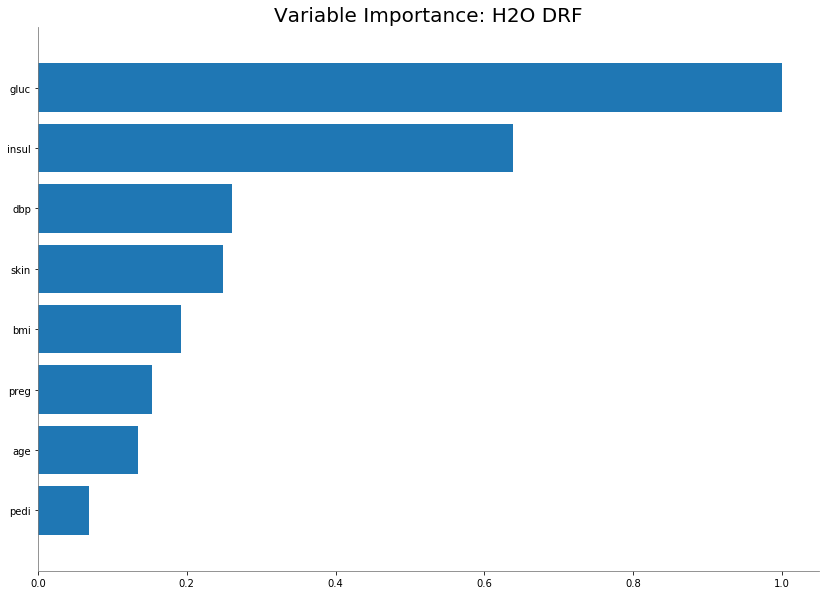

In [7]:
diabetes_RF.varimp_plot()

**Conclusion: importance of inputs aligned with medical knowledge in diabetes**

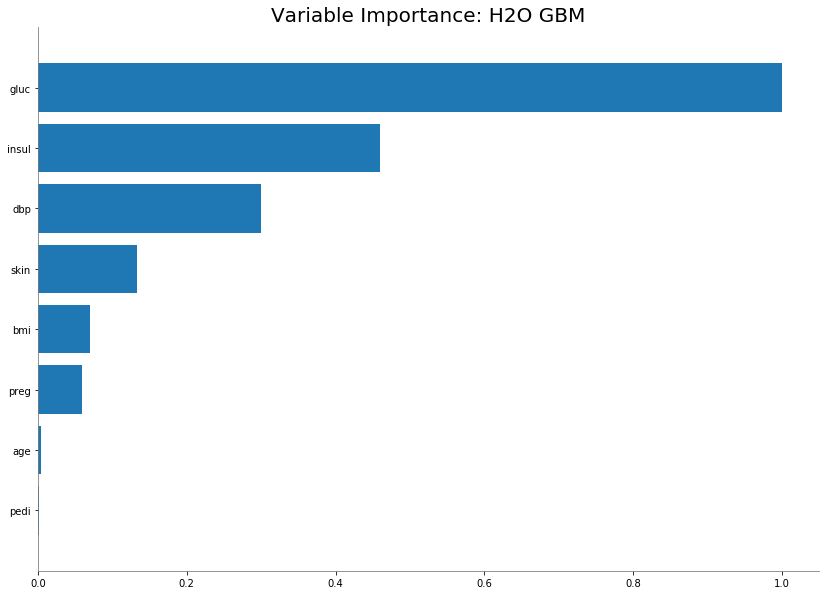

In [9]:
diabetes_gbm.varimp_plot()

**Ditto above comment**

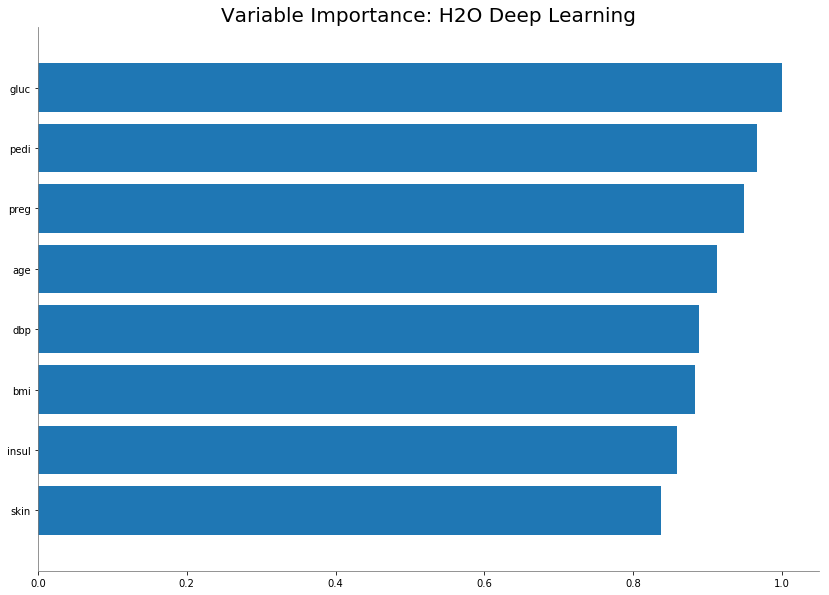

In [10]:
diabetes_dl.varimp_plot()

**Conclusion: relatively flat importances - may need additional training and tuning** 

## Partial Dependence Plots
***
Partial dependence plots (PDP) can be used to aid interpretability. PDPs plot the predicted response of a ML algorithm over the domain of an input while holding other inputs constant at their mean values.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528240244791_1540 on column 'gluc'



gluc,mean_response,stddev_response
0,0.3429807,0.3062096
44,0.0873747,0.1970945
56,0.0899237,0.1993548
57,0.0687698,0.1821256
61,0.1473571,0.2167195
---,---,---
195,0.8201191,0.2588779
196,0.7543307,0.2978057
197,0.8494568,0.2531276
198,0.7081417,0.3119906



See the whole table with table.as_data_frame()


[]

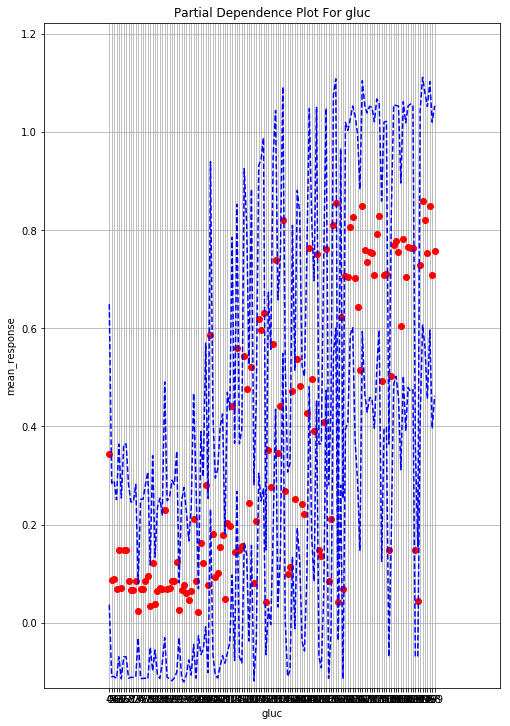

In [4]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['gluc'], nbins = 140, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'insul'



insul,mean_response,stddev_response
0,0.3708928,0.4136500
14,0.3738733,0.4008415
15,0.2805170,0.3700170
16,0.2848147,0.3718091
18,0.2808289,0.3701797
---,---,---
579,0.3727252,0.4003450
600,0.4204299,0.4050309
680,0.2953124,0.3776024
744,0.0446055,0.0922773



See the whole table with table.as_data_frame()


[]

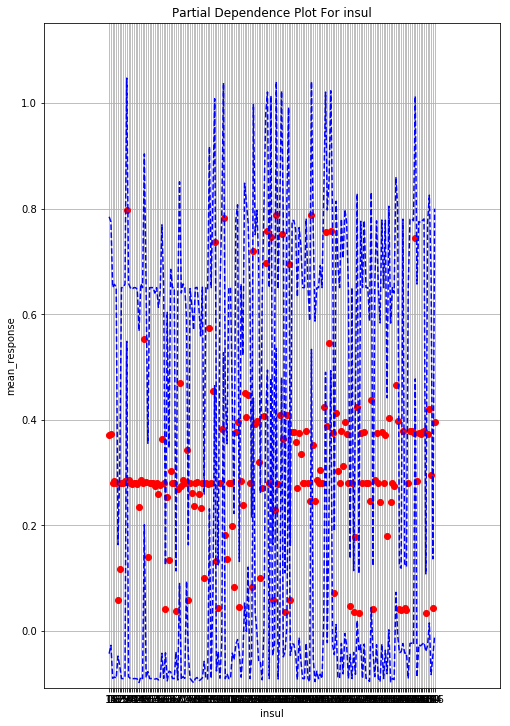

In [13]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['insul'], nbins = 190, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'dbp'



dbp,mean_response,stddev_response
0,0.3942493,0.4336197
24,0.3449818,0.4203914
30,0.3551964,0.4230851
38,0.3283768,0.4141516
40,0.3646162,0.4218027
---,---,---
106,0.3489381,0.4224444
108,0.4070699,0.4271990
110,0.3597868,0.4266052
114,0.3572819,0.4257350



See the whole table with table.as_data_frame()


[]

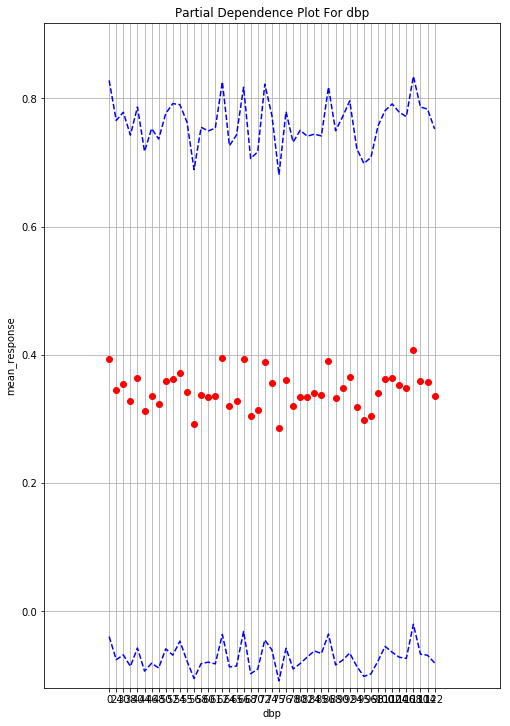

In [14]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['dbp'], nbins = 50, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'skin'



skin,mean_response,stddev_response
0,0.3385618,0.4276842
7,0.3290573,0.4214023
8,0.3365160,0.4249475
10,0.3292230,0.4212474
11,0.3364585,0.4252299
---,---,---
52,0.3361451,0.4259911
54,0.3355401,0.4255158
56,0.3431275,0.4279860
60,0.3261131,0.4194928



See the whole table with table.as_data_frame()


[]

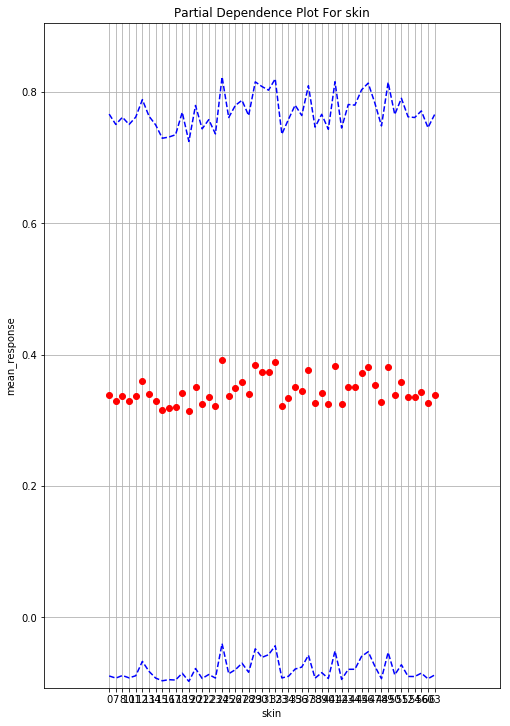

In [15]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['skin'], nbins = 60, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'preg'



preg,mean_response,stddev_response
0,0.3402174,0.4365837
1,0.3362680,0.4351314
2,0.3319438,0.4311541
3,0.3465170,0.4387156
4,0.3401904,0.4369808
5,0.3469460,0.4363553
6,0.3432286,0.4352383
7,0.3721171,0.4287632
8,0.3690376,0.4360261
9,0.3630868,0.4361697


[]

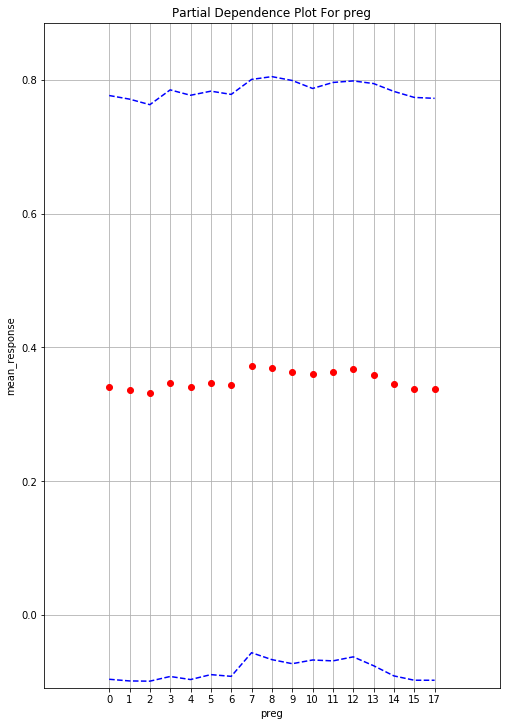

In [16]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['preg'], nbins = 20, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'bmi'



bmi,mean_response,stddev_response
0.0,0.2553944,0.3513000
4.7928571,0.2553944,0.3513000
9.5857143,0.2553944,0.3513000
14.3785714,0.2553944,0.3513000
19.1714286,0.2553944,0.3513000
23.9642857,0.2553944,0.3513000
28.7571429,0.3486027,0.4247481
33.55,0.3747210,0.4408063
38.3428571,0.3750883,0.4407858
43.1357143,0.3890333,0.4404843


[]

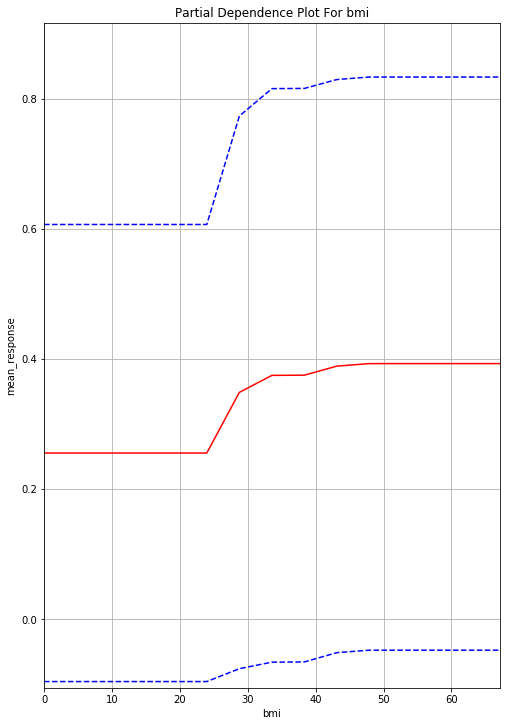

In [17]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['bmi'], nbins = 15, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'age'



age,mean_response,stddev_response
21.0,0.3522331,0.4471068
27.6666667,0.3522331,0.4471068
34.3333333,0.3552298,0.4480222
41.0,0.3567767,0.4479316
47.6666667,0.3567767,0.4479316
54.3333333,0.3567767,0.4479316
61.0,0.3561540,0.4474414
67.6666667,0.3511388,0.4447623
74.3333333,0.3511388,0.4447623
81.0,0.3511388,0.4447623


[]

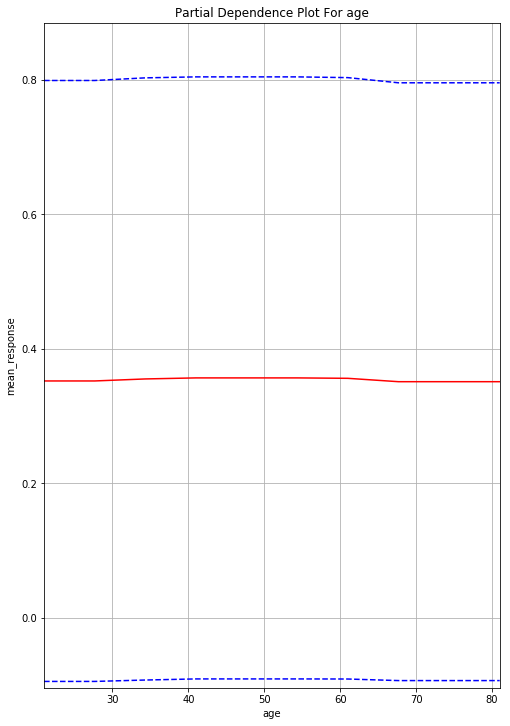

In [18]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['age'], nbins = 10, plot = True, plot_stddev = True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1528082413303_4902 on column 'pedi'



pedi,mean_response,stddev_response
0.078,0.3414621,0.4395635
0.1755833,0.3533343,0.4475699
0.2731667,0.3558407,0.4493405
0.37075,0.3558407,0.4493405
0.4683333,0.3558407,0.4493405
---,---,---
2.0296667,0.3558407,0.4493405
2.12725,0.3558407,0.4493405
2.2248333,0.3558407,0.4493405
2.3224167,0.3558407,0.4493405



See the whole table with table.as_data_frame()


[]

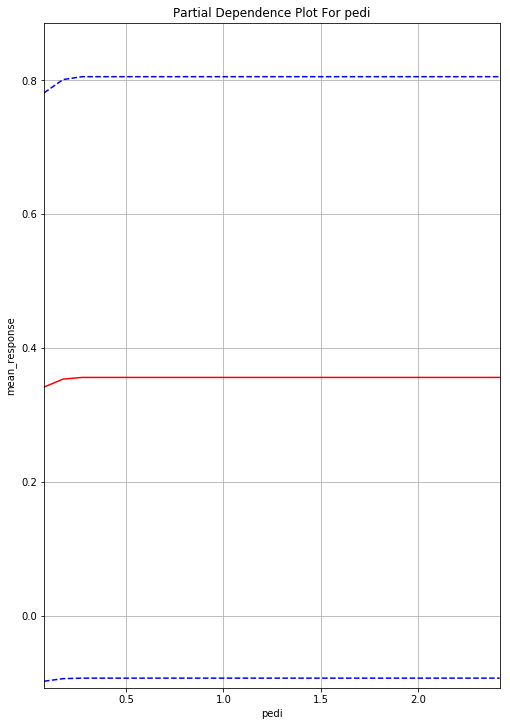

In [19]:
# Partial Dependence Plot for GBM
%matplotlib inline
diabetes_gbm.partial_plot(train, cols = ['pedi'], nbins = 25, plot = True, plot_stddev = True)

# GBM Tuning
***
The two primay methods for tuning the hyper parameters in H2O are grid search and random search.

### Grid Search

In [6]:
# Import H2O Grid Search
from h2o.grid.grid_search import H2OGridSearch

# Use Cartesian Grid Search to find best max depth
# Max depth can have a big impact on training time so we will first narrow down the best max depths

hyper_params = {'max_depth' : list(range(1, 25, 2))}

gbm_grid = H2OGradientBoostingEstimator(
    ## more trees is better if the learning rate is small enough 
    ## here, use "more than enough" trees - we have early stopping
    ntrees = 30, 
    
    ## smaller learning rate is better
    ## since we have learning_rate_annealing, we can afford to start with a bigger learning rate
    learn_rate = 0.027,                                                         
    
    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
    ## (use 1.00 to disable, but then lower the learning_rate)
    learn_rate_annealing = 0.99,                                               
    
    ## sample 80% of rows per tree
    sample_rate = 0.8,                                                       
   
    ## sample 80% of columns per split
    col_sample_rate = 0.8, 
    
    ## fix a random number generator seed for reproducibility
    seed = 4321,                                                             
    
    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5,
    stopping_tolerance = 0.001,
    stopping_metric = "AUC", 
  
    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10    
)

# Build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(gbm_grid, 
                     hyper_params, 
                     grid_id = 'depth_grid',
                     search_criteria = {'strategy': "Cartesian"})

# Train grid search
grid.train(x = inputs, 
           y = output,
           training_frame = train,
           validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [7]:
## by default, display the grid search results sorted by increasing logloss (since this is a classification task)
grid  

     max_depth            model_ids             logloss
0           11   depth_grid_model_5  0.5584916874339082
1           15   depth_grid_model_7  0.5585094614909165
2           21  depth_grid_model_10  0.5585094614909165
3           23  depth_grid_model_11  0.5585094614909165
4           17   depth_grid_model_8  0.5585094614909165
5           19   depth_grid_model_9  0.5585094614909165
6           13   depth_grid_model_6  0.5585151407151205
7            7   depth_grid_model_3   0.558947494173252
8            9   depth_grid_model_4   0.559498119053973
9            3   depth_grid_model_1  0.5653713606357852
10           5   depth_grid_model_2  0.5655820827123121
11           1   depth_grid_model_0  0.5758163772055899


In [8]:
## sort the grid models by decreasing AUC

sorted_grid = grid.get_grid(sort_by="auc", decreasing = True)    
sorted_grid.sorted_metric_table()[0:4]

,,max_depth,model_ids,auc
0,,1,depth_grid_model_0,0.763103318250377
1,,7,depth_grid_model_3,0.7417043740573153
2,,3,depth_grid_model_1,0.7378393665158371
3,,13,depth_grid_model_6,0.7371794871794872


In [10]:
## find the range of max_depth for the top 5 models
top_depths = sorted_grid.sorted_metric_table()['max_depth'][0:4] 
new_min = int(min(top_depths, key = int))
print('New min is ', new_min)
new_max = int(max(top_depths, key = int))
print('New max is ', new_max)

New min is  1
New max is  13


### Random Search
***
The random search strategy H2O uses to optimize the hyper parameters is described in [Bergstra J, Bengio Y. Random Search for Hyper-Parameter Optimization. Journal of Machine Learning Research. 2012;  13:281-305.](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

In [11]:
# Final Random Discrete Hyper-parameterization
import math

hyper_params_tune = {'max_depth': list(range(new_min, new_max + 1, 1)),
                     'sample_rate': [x/100. for x in range(20, 101)],
                     'col_sample_rate': [x/100. for x in range(20, 101)],
                     'min_rows': [2**x for x in range(0, int(math.log(train.nrow, 2) - 1) + 1)],
                     'nbins_cats': [2**x for x in range(4, 13, 1)],
                     'histogram_type': ["UniformAdaptive", "QuantilesGlobal"]
                    }

search_criteria_tune = {
    ## Random grid search
    'strategy': "RandomDiscrete",
    
    ## limit the runtime to 60 minutes
    'max_runtime_secs': 3600,         
  
    ## build no more than 100 models
    'max_models': 100,                  
  
    ## random number generator seed to make sampling of parameter combinations reproducible
    'seed': 4321,                        
  
    ## early stopping once the leaderboard of the top 5 models is converged to 0.1% relative difference
    'stopping_rounds': 5,                
    'stopping_metric': "AUC",
    'stopping_tolerance': 0.001
}

In [12]:
gbm_final_grid = H2OGradientBoostingEstimator(
    ## more trees is better if the learning rate is small enough 
    ## here, use "more than enough" trees - we have early stopping
    ntrees = 30, 
    
    ## smaller learning rate is better
    ## since we have learning_rate_annealing, we can afford to start with a bigger learning rate
    learn_rate = 0.027,                                                         
    
    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
    ## (use 1.00 to disable, but then lower the learning_rate)
    learn_rate_annealing = 0.99,      
    
    ## fix a random number generator seed for reproducibility
    seed = 4321,                                                             
    
    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5,
    stopping_tolerance = 0.001,
    stopping_metric = "AUC", 
    
    ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
    max_runtime_secs = 3600,
  
    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10    
)

final_grid = H2OGridSearch(gbm_final_grid, 
                           hyper_params = hyper_params_tune,
                           grid_id = 'final_grid',
                           search_criteria = search_criteria_tune)

# Train final grid search
final_grid.train(x = inputs, 
                 y = output,
                 training_frame = train,
                 validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [13]:
## Sort the grid models by AUC

sorted_final_grid = final_grid.get_grid(sort_by = "auc", decreasing = True)    
sorted_final_grid.sorted_metric_table()[0:4]

,,col_sample_rate,histogram_type,max_depth,min_rows,nbins_cats,sample_rate,model_ids,auc
0,,0.29,UniformAdaptive,13,64.0,16,0.65,final_grid_model_36,0.8376696832579186
1,,0.21,QuantilesGlobal,12,8.0,16,0.89,final_grid_model_75,0.8291855203619909
2,,0.85,QuantilesGlobal,12,64.0,16,0.53,final_grid_model_61,0.8277714932126697
3,,0.26,QuantilesGlobal,10,2.0,16,0.91,final_grid_model_1,0.8231523378582202


In [14]:
# Final Test Scoring
# How well does our best model do on the final hold out dataset

best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(valid)

print("AUC on validation: " + str(best_model.auc(valid = True)))
print("AUC on test: " + str(performance_best_model.auc()))

AUC on validation: 0.8376696832579186
AUC on test: 0.8376696832579186


**Using H2O's grid search module did not improve model accuracy over the default settings. Imploying a random search strategy only increased accuracy by one percentage point over the defaults.**

## Stacked Ensembles - DRAFT

In [15]:
#import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function

# create training and test datasets for model validation
train, test = diabetes.split_frame(ratios = [.8], seed = 4321)

# Identify predictors and response
x = train.columns
y = "class"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Number of CV folds (to generate level-one data for stacking)
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 1. Generate a 2-model ensemble (GBM + RF)

# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=30,
                                      max_depth=23,
                                      min_rows=2,
                                      learn_rate=0.027,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)


# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=train)


# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)


# 2. Generate a random grid of models and stack them together

# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [6, 12, 23],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.5, 0.6, 0.7, 0.8, 0.9]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 30, "seed": 1}

# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")
grid.train(x=x, y=y, training_frame=train)

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)

# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test_data=test).auc() for model in grid.model_ids])
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.7584745762711865
Ensemble Test AUC:  0.7601176063645798
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.7623659633344864
Ensemble Test AUC:  0.7448979591836735
stackedensemble prediction progress: |████████████████████████████████████| 100%


# AutoML-DRAFT

In [16]:
#import h2o
from h2o.automl import H2OAutoML

# create training and test datasets for model validation
train, test = diabetes.split_frame(ratios = [.8], seed = 4321)

# Identify predictors and response
x = train.columns
y = "class"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 30 seconds
aml = H2OAutoML(max_runtime_secs = 30)
aml.train(x = x, y = y,
          training_frame = train)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb)

# The leader model is stored here
#aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)

# or:
#preds = aml.leader.predict(test)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


model_id,auc,logloss
StackedEnsemble_AllModels_0_AutoML_20180605_195123,0.768363,0.542392
StackedEnsemble_BestOfFamily_0_AutoML_20180605_195123,0.761049,0.547513
XRT_0_AutoML_20180605_195123,0.758237,0.601773
GLM_grid_0_AutoML_20180605_195123_model_0,0.753735,0.557243
GBM_grid_0_AutoML_20180605_195123_model_5,0.718241,0.619348
DeepLearning_grid_0_AutoML_20180605_195123_model_0,0.714926,2.34115
GBM_grid_0_AutoML_20180605_195123_model_0,0.690545,0.759324
GBM_grid_0_AutoML_20180605_195123_model_11,0.686838,0.629176
DRF_0_AutoML_20180605_195123,0.684793,1.07631
GBM_grid_0_AutoML_20180605_195123_model_7,0.680994,0.657062


In [28]:
# Shutdown h2o cluster
#h2o.cluster().shutdown()

H2O session _sid_8efe closed.
